In [1]:
from tensorflow import keras
keras.__version__

'2.4.0'

To start using `zoo.orca`, we need to first initialize orca context. Here we specify local or distributed mode. In this example, we choose the local mode.

In [2]:
from zoo.orca import init_orca_context, stop_orca_context
from zoo.orca import OrcaContext

# recommended to set it to True when running Analytics Zoo in Jupyter notebook. 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

cluster_mode = "local"

if cluster_mode == "local":
    init_orca_context(cores=1, memory="2g")   # run in local mode
elif cluster_mode == "k8s":
    init_orca_context(cluster_mode="k8s", num_nodes=2, cores=4) # run on K8s cluster
elif cluster_mode == "yarn":
    init_orca_context(
        cluster_mode="yarn-client", cores=4, num_nodes=2, memory="2g",
        driver_memory="10g", driver_cores=1,
        conf={"spark.rpc.message.maxSize": "1024",
              "spark.task.maxFailures": "1",
              "spark.driver.extraJavaOptions": "-Dbigdl.failure.retryTimes=1"})   # run on Hadoop YARN cluster

Initializing orca context
Current pyspark location is : /intern/spark/spark-2.4.3-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /home/zhenhao/analytics-zoo/zoo/target/analytics-zoo-bigdl_0.12.1-spark_2.4.3-0.10.0-SNAPSHOT-dist-all/lib/analytics-zoo-bigdl_0.12.1-spark_2.4.3-0.10.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 


SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/home/zhenhao/analytics-zoo/zoo/target/analytics-zoo-bigdl_0.12.1-spark_2.4.3-0.10.0-SNAPSHOT-dist-all/lib/analytics-zoo-bigdl_0.12.1-spark_2.4.3-0.10.0-SNAPSHOT-jar-with-dependencies.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/intern/spark/spark-2.4.3-bin-hadoop2.7/jars/slf4j-log4j12-1.7.16.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


2021-02-19 11:46:01 WARN  Utils:66 - Your hostname, intern01 resolves to a loopback address: 127.0.1.1; using 10.239.44.107 instead (on interface eno1)
2021-02-19 11:46:01 WARN  Utils:66 - Set SPARK_LOCAL_IP if you need to bind to another address
2021-02-19 11:46:01 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
cls.getname: com.intel.analytics.bigdl.python.api.Sample
BigDLBasePickler registering: bigdl.util.common  Sample
cls.getname: com.intel.analytics.bigdl.python.api.EvaluatedResult
BigDLBasePickler registering: bigdl.util.common  EvaluatedResult
cls.getname: com.intel.analytics.bigdl.python.api.JTensor
BigDLBasePickler registering: bigdl.util.common  JTensor
cls.getname: com.intel.analytics.bigdl.python.api.JActivity
Successfully got a SparkContextBigDLBasePickler registering: bigdl.util.common  JActivity




User settings:

   KMP_AFFINITY=granularity=fine,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   OMP_NUM_THREADS=1

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_HAND_THREAD=false
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_FORKJOIN_FRAMES=true
   KMP_FORKJOIN_FRAMES_MODE=3
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_INIT_WAIT=2048
   KMP_ITT_PREPARE_DELAY=0
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NEXT_WAIT=1024
   KMP_NUM_L

# Predicting house prices: a regression example
This notebook contains the code samples found in Chapter 3, Section 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

------------------

In our two previous examples, we were considering classification problems, where the goal was to predict a single discrete label of an input data point. Another common type of machine learning problem is "regression", which consists of predicting a continuous value instead of a discrete label. For instance, predicting the temperature tomorrow, given meteorological data, or predicting the time that a software project will take to complete, given its specifications.

Do not mix up "regression" with the algorithm "logistic regression": confusingly, "logistic regression" is not a regression algorithm, it is a classification algorithm.

## The Boston Housing Price dataset

We will be attempting to predict the median price of homes in a given Boston suburb in the mid-1970s, given a few data points about the suburb at the time, such as the crime rate, the local property tax rate, etc.

The dataset we will be using has another interesting difference from our two previous examples: it has very few data points, only 506 in total, split between 404 training samples and 102 test samples, and each "feature" in the input data (e.g. the crime rate is a feature) has a different scale. For instance some values are proportions, which take a values between 0 and 1, others take values between 1 and 12, others between 0 and 100...

Let's take a look at the data:

In [3]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()
train_data.shape

Using TensorFlow backend.


(404, 13)

In [4]:
test_data.shape

(102, 13)


As you can see, we have 404 training samples and 102 test samples. The data comprises 13 features. The 13 features in the input data are as follow:

1. Per capita crime rate.
1. Proportion of residential land zoned for lots over 25,000 square feet.
1. Proportion of non-retail business acres per town.
1. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
1. Nitric oxides concentration (parts per 10 million).
1. Average number of rooms per dwelling.
1. Proportion of owner-occupied units built prior to 1940.
1. Weighted distances to five Boston employment centres.
1. Index of accessibility to radial highways.
1. Full-value property-tax rate per $10,000.
1. Pupil-teacher ratio by town.
1. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
1. % lower status of the population.

The targets are the median values of owner-occupied homes, in thousands of dollars:

In [5]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

The prices are typically between \$ 10,000 and \$ 50,000. If that sounds cheap, remember this was the mid-1970s, and these prices are not inflation-adjusted.

## Preparing the data

It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), we will subtract the mean of the feature and divide by the standard deviation, so that the feature will be centered around 0 and will have a unit standard deviation. We can directly use the numbers calculated above.

We can extract the mean and standard deviation of our dataset using `numpy`.

In [6]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data -= mean
train_data /= std
test_data -= mean
test_data /= std

### Data Type Transformation
We can define the dataset using standard pytorch `DataLoader`.

In [94]:
import torch
from torch.utils.data import TensorDataset, DataLoader

def data_loader_creator(data, targets, batch_size, shuffle=True):
    """
    Transforms data and targets from np.array to torch.utils.data.DataLoader,
    and shuffle the dataset if `shuffle` is set to true.
    """
    
    data_tensor = torch.Tensor([np.array(x) for x in data])
    targets_tensor = torch.Tensor([np.array([x]) for x in targets])
    dataset = TensorDataset(data_tensor, targets_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

### Validating our approach using K-fold validation
To evaluate our network while we keep adjusting its parameters (such as the number of epochs used for training), we could simply split the data into a training set and a validation set, as we were doing in our previous examples. However, because we have so few data points, the validation set would end up being very small (e.g. about 100 examples). A consequence is that our validation scores may change a lot depending on which data points we choose to use for validation and which we choose for training, i.e. the validation scores may have a high variance with regard to the validation split. This would prevent us from reliably evaluating our model.

The best practice in such situations is to use K-fold cross-validation. It consists of splitting the available data into K partitions (typically K=4 or 5), then instantiating K identical models, and training each one on K-1 partitions while evaluating on the remaining partition. The validation score for the model used would then be the average of the K validation scores obtained.

The validation data creator can be created in the similar fashion. We also use the `config["K-fold"]` here. If it is set to `True`, we use the 1/4 of the training set (that is not in the training data) as validation data. Otherwise we use the test set as the validation data.


Note that the quantities that we use for normalizing the test data have been computed using the training data. We should never use in our workflow any quantity computed on the test data, even for something as simple as data normalization.

## Building our network
Because so few samples are available, we will be using a very small network with two hidden layers, each with 64 units. In general, the less training data you have, the worse overfitting will be, and using a small network is one way to mitigate overfitting.

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RegressionNet(nn.Module):
    def __init__(self):
        super(RegressionNet, self).__init__()
        self.hidden_1 = nn.Linear(13, 64)
        self.hidden_2 = nn.Linear(64, 64)
        self.predict = nn.Linear(64, 1)
        
    def forward(self, x):
        x = F.relu(self.hidden_1(x))
        x = F.relu(self.hidden_2(x))
        x = self.predict(x)
        return x

model = RegressionNet()
#model.train()
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.2)

In [ ]:
print(model)

Our network ends with a single unit, and no activation (i.e. it will be linear layer). This is a typical setup for scalar regression (i.e. regression where we are trying to predict a single continuous value). Applying an activation function would constrain the range that the output can take; for instance if we applied a sigmoid activation function to our last layer, the network could only learn to predict values between 0 and 1. Here, because the last layer is purely linear, the network is free to learn to predict values in any range.

Note that we are compiling the network with the `mse` loss function -- Mean Squared Error, the square of the difference between the predictions and the targets, a widely used loss function for regression problems.

We are also monitoring a new metric during training: `mae`. This stands for Mean Absolute Error. It is simply the absolute value of the difference between the predictions and the targets. For instance, a MAE of 0.5 on this problem would mean that our predictions are off by \$500 on average.

## Fit with Orca Estimator
We can create the estimator with the following, and we can fit our data using the estimator. Let's try training the network for a bit longer: 500 epochs. To keep a record of how well the model did at each epoch, we will modify our training loop to save the per-epoch validation score log:

In [113]:
from zoo.orca.learn.pytorch import Estimator 
from zoo.orca.learn.metrics import MAE

est = Estimator.from_torch(model=model, optimizer=optimizer, loss=criterion, metrics=[MAE()])

creating: createZooKerasMAE
creating: createTorchLoss
creating: createTorchOptim
creating: createTorchModel
creating: createEstimator


In [114]:
train_loader = data_loader_creator(train_data, train_targets, batch_size=16)
test_loader = data_loader_creator(test_data, test_targets, batch_size=1, shuffle=False)

In [115]:
from zoo.orca.learn.trigger import EveryEpoch

result = est.fit(data=train_loader, epochs=80, checkpoint_trigger=EveryEpoch(), validation_data=test_loader)

creating: createEveryEpoch
creating: createMaxEpoch
2021-02-19 16:17:25 INFO  DistriOptimizer$:818 - caching training rdd ...


2021-02-19 16:17:54 INFO  DistriOptimizer$:649 - Cache thread models...
2021-02-19 16:17:54 WARN  DistriOptimizer$:604 - Partitions of the training data are not evenlydistributed across the executors in the Spark cluster; are there sufficient trainingdata to be distributed?
2021-02-19 16:17:54 INFO  DistriOptimizer$:632 - model thread pool size is 1
2021-02-19 16:17:54 INFO  DistriOptimizer$:651 - Cache thread models... done
2021-02-19 16:17:54 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at

Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021-02-19 16:17:55 INFO  DistriOptimizer$:177 - [Epoch 1 416/416][

2021-02-19 16:17:56 INFO  DistriOptimizer$:427 - [Epoch 3 192/416][Iteration 64][Wall Clock 1.363363477s] Trained 16.0 records in 0.014626217 seconds. Throughput is 1093.926 records/second. Loss is 4.4448457. 
2021-02-19 16:17:56 INFO  DistriOptimizer$:427 - [Epoch 3 208/416][Iteration 65][Wall Clock 1.377504971s] Trained 16.0 records in 0.014141494 seconds. Throughput is 1131.4221 records/second. Loss is 41.667435. 
2021-02-19 16:17:56 INFO  DistriOptimizer$:427 - [Epoch 3 224/416][Iteration 66][Wall Clock 1.393597869s] Trained 16.0 records in 0.016092898 seconds. Throughput is 994.22736 records/second. Loss is 12.432277. 
2021-02-19 16:17:56 INFO  DistriOptimizer$:427 - [Epoch 3 240/416][Iteration 67][Wall Clock 1.408033323s] Trained 16.0 records in 0.014435454 seconds. Throughput is 1108.3822 records/second. Loss is 19.216503. 
2021-02-19 16:17:56 INFO  DistriOptimizer$:427 - [Epoch 3 256/416][Iteration 68][Wall Clock 1.423695832s] Trained 16.0 records in 0.015662509 seconds. Throug

2021-02-19 16:17:56 INFO  DistriOptimizer$:427 - [Epoch 4 224/416][Iteration 92][Wall Clock 2.006766754s] Trained 16.0 records in 0.026574661 seconds. Throughput is 602.07733 records/second. Loss is 7.9761257. 
2021-02-19 16:17:56 INFO  DistriOptimizer$:427 - [Epoch 4 240/416][Iteration 93][Wall Clock 2.033296734s] Trained 16.0 records in 0.02652998 seconds. Throughput is 603.09125 records/second. Loss is 9.739827. 
2021-02-19 16:17:56 INFO  DistriOptimizer$:427 - [Epoch 4 256/416][Iteration 94][Wall Clock 2.05597336s] Trained 16.0 records in 0.022676626 seconds. Throughput is 705.5723 records/second. Loss is 13.700854. 
2021-02-19 16:17:56 INFO  DistriOptimizer$:427 - [Epoch 4 272/416][Iteration 95][Wall Clock 2.079266917s] Trained 16.0 records in 0.023293557 seconds. Throughput is 686.88525 records/second. Loss is 9.933357. 
2021-02-19 16:17:56 INFO  DistriOptimizer$:427 - [Epoch 4 288/416][Iteration 96][Wall Clock 2.094378388s] Trained 16.0 records in 0.015111471 seconds. Throughput

2021-02-19 16:17:57 INFO  DistriOptimizer$:427 - [Epoch 5 336/416][Iteration 125][Wall Clock 2.818226359s] Trained 16.0 records in 0.024134337 seconds. Throughput is 662.9558 records/second. Loss is 15.24097. 
2021-02-19 16:17:57 INFO  DistriOptimizer$:427 - [Epoch 5 352/416][Iteration 126][Wall Clock 2.847308985s] Trained 16.0 records in 0.029082626 seconds. Throughput is 550.1566 records/second. Loss is 10.434586. 
2021-02-19 16:17:57 INFO  DistriOptimizer$:427 - [Epoch 5 368/416][Iteration 127][Wall Clock 2.862948549s] Trained 16.0 records in 0.015639564 seconds. Throughput is 1023.04645 records/second. Loss is 15.30513. 
2021-02-19 16:17:57 INFO  DistriOptimizer$:427 - [Epoch 5 384/416][Iteration 128][Wall Clock 2.883789295s] Trained 16.0 records in 0.020840746 seconds. Throughput is 767.72687 records/second. Loss is 8.991439. 
2021-02-19 16:17:57 INFO  DistriOptimizer$:427 - [Epoch 5 400/416][Iteration 129][Wall Clock 2.904643751s] Trained 16.0 records in 0.020854456 seconds. Thro

Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021-02-19 16:17:58 INFO  DistriOptimizer$:177 - [Epoch 6 416/416][

2021-02-19 16:17:59 INFO  DistriOptimizer$:427 - [Epoch 8 160/416][Iteration 192][Wall Clock 4.657446191s] Trained 16.0 records in 0.022923544 seconds. Throughput is 697.97235 records/second. Loss is 11.817242. 
2021-02-19 16:17:59 INFO  DistriOptimizer$:427 - [Epoch 8 176/416][Iteration 193][Wall Clock 4.680739472s] Trained 16.0 records in 0.023293281 seconds. Throughput is 686.8934 records/second. Loss is 39.643143. 
2021-02-19 16:17:59 INFO  DistriOptimizer$:427 - [Epoch 8 192/416][Iteration 194][Wall Clock 4.701378543s] Trained 16.0 records in 0.020639071 seconds. Throughput is 775.2287 records/second. Loss is 21.599802. 
2021-02-19 16:17:59 INFO  DistriOptimizer$:427 - [Epoch 8 208/416][Iteration 195][Wall Clock 4.718400468s] Trained 16.0 records in 0.017021925 seconds. Throughput is 939.96423 records/second. Loss is 10.023748. 
2021-02-19 16:17:59 INFO  DistriOptimizer$:427 - [Epoch 8 224/416][Iteration 196][Wall Clock 4.739340593s] Trained 16.0 records in 0.020940125 seconds. Th

2021-02-19 16:18:00 INFO  DistriOptimizer$:427 - [Epoch 9 320/416][Iteration 228][Wall Clock 5.564968863s] Trained 16.0 records in 0.032248763 seconds. Throughput is 496.1431 records/second. Loss is 21.824287. 
2021-02-19 16:18:00 INFO  DistriOptimizer$:427 - [Epoch 9 336/416][Iteration 229][Wall Clock 5.582463849s] Trained 16.0 records in 0.017494986 seconds. Throughput is 914.5477 records/second. Loss is 59.25161. 
2021-02-19 16:18:00 INFO  DistriOptimizer$:427 - [Epoch 9 352/416][Iteration 230][Wall Clock 5.6017538s] Trained 16.0 records in 0.019289951 seconds. Throughput is 829.4474 records/second. Loss is 29.54064. 
2021-02-19 16:18:00 INFO  DistriOptimizer$:427 - [Epoch 9 368/416][Iteration 231][Wall Clock 5.623233628s] Trained 16.0 records in 0.021479828 seconds. Throughput is 744.8849 records/second. Loss is 41.475983. 
2021-02-19 16:18:00 INFO  DistriOptimizer$:427 - [Epoch 9 384/416][Iteration 232][Wall Clock 5.640334742s] Trained 16.0 records in 0.017101114 seconds. Throughp

Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021-02-19 16:18:01 INFO  DistriOptimizer$:177 - [Epoch 10 416/416]

2021-02-19 16:18:02 INFO  DistriOptimizer$:427 - [Epoch 12 176/416][Iteration 297][Wall Clock 7.388855466s] Trained 16.0 records in 0.022570974 seconds. Throughput is 708.87506 records/second. Loss is 19.2488. 
2021-02-19 16:18:02 INFO  DistriOptimizer$:427 - [Epoch 12 192/416][Iteration 298][Wall Clock 7.406032532s] Trained 16.0 records in 0.017177066 seconds. Throughput is 931.47455 records/second. Loss is 8.449383. 
2021-02-19 16:18:02 INFO  DistriOptimizer$:427 - [Epoch 12 208/416][Iteration 299][Wall Clock 7.425929429s] Trained 16.0 records in 0.019896897 seconds. Throughput is 804.1455 records/second. Loss is 12.923439. 
2021-02-19 16:18:02 INFO  DistriOptimizer$:427 - [Epoch 12 224/416][Iteration 300][Wall Clock 7.447766758s] Trained 16.0 records in 0.021837329 seconds. Throughput is 732.6903 records/second. Loss is 9.37282. 
2021-02-19 16:18:02 INFO  DistriOptimizer$:427 - [Epoch 12 240/416][Iteration 301][Wall Clock 7.464613328s] Trained 16.0 records in 0.01684657 seconds. Thr

2021-02-19 16:18:02 INFO  DistriOptimizer$:427 - [Epoch 13 336/416][Iteration 333][Wall Clock 8.273541834s] Trained 16.0 records in 0.017419865 seconds. Throughput is 918.4916 records/second. Loss is 20.442768. 
2021-02-19 16:18:02 INFO  DistriOptimizer$:427 - [Epoch 13 352/416][Iteration 334][Wall Clock 8.291434074s] Trained 16.0 records in 0.01789224 seconds. Throughput is 894.24243 records/second. Loss is 8.788978. 
2021-02-19 16:18:03 INFO  DistriOptimizer$:427 - [Epoch 13 368/416][Iteration 335][Wall Clock 8.311007547s] Trained 16.0 records in 0.019573473 seconds. Throughput is 817.43286 records/second. Loss is 10.188566. 
2021-02-19 16:18:03 INFO  DistriOptimizer$:427 - [Epoch 13 384/416][Iteration 336][Wall Clock 8.333200682s] Trained 16.0 records in 0.022193135 seconds. Throughput is 720.94366 records/second. Loss is 7.2746296. 
2021-02-19 16:18:03 INFO  DistriOptimizer$:427 - [Epoch 13 400/416][Iteration 337][Wall Clock 8.352962912s] Trained 16.0 records in 0.01976223 seconds.

Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021-02-19 16:18:03 INFO  DistriOptimizer$:177 - [Epoch 14 416/416]

2021-02-19 16:18:04 INFO  DistriOptimizer$:427 - [Epoch 16 160/416][Iteration 400][Wall Clock 10.112351125s] Trained 16.0 records in 0.016741698 seconds. Throughput is 955.6975 records/second. Loss is 5.658617. 
2021-02-19 16:18:04 INFO  DistriOptimizer$:427 - [Epoch 16 176/416][Iteration 401][Wall Clock 10.132846532s] Trained 16.0 records in 0.020495407 seconds. Throughput is 780.6627 records/second. Loss is 15.378379. 
2021-02-19 16:18:04 INFO  DistriOptimizer$:427 - [Epoch 16 192/416][Iteration 402][Wall Clock 10.152527311s] Trained 16.0 records in 0.019680779 seconds. Throughput is 812.97595 records/second. Loss is 32.20664. 
2021-02-19 16:18:04 INFO  DistriOptimizer$:427 - [Epoch 16 208/416][Iteration 403][Wall Clock 10.173592654s] Trained 16.0 records in 0.021065343 seconds. Throughput is 759.5414 records/second. Loss is 25.234081. 
2021-02-19 16:18:04 INFO  DistriOptimizer$:427 - [Epoch 16 224/416][Iteration 404][Wall Clock 10.196059253s] Trained 16.0 records in 0.022466599 seco

2021-02-19 16:18:05 INFO  DistriOptimizer$:427 - [Epoch 17 176/416][Iteration 427][Wall Clock 10.821292179s] Trained 16.0 records in 0.017825934 seconds. Throughput is 897.5687 records/second. Loss is 20.813843. 
2021-02-19 16:18:05 INFO  DistriOptimizer$:427 - [Epoch 17 192/416][Iteration 428][Wall Clock 10.838453005s] Trained 16.0 records in 0.017160826 seconds. Throughput is 932.3561 records/second. Loss is 9.074695. 
2021-02-19 16:18:05 INFO  DistriOptimizer$:427 - [Epoch 17 208/416][Iteration 429][Wall Clock 10.855826534s] Trained 16.0 records in 0.017373529 seconds. Throughput is 920.9413 records/second. Loss is 6.0922914. 
2021-02-19 16:18:05 INFO  DistriOptimizer$:427 - [Epoch 17 224/416][Iteration 430][Wall Clock 10.872471888s] Trained 16.0 records in 0.016645354 seconds. Throughput is 961.22925 records/second. Loss is 7.2431107. 
2021-02-19 16:18:05 INFO  DistriOptimizer$:427 - [Epoch 17 240/416][Iteration 431][Wall Clock 10.900730877s] Trained 16.0 records in 0.028258989 sec

2021-02-19 16:18:06 INFO  DistriOptimizer$:427 - [Epoch 18 336/416][Iteration 463][Wall Clock 11.680108983s] Trained 16.0 records in 0.018455583 seconds. Throughput is 866.9463 records/second. Loss is 8.556161. 
2021-02-19 16:18:06 INFO  DistriOptimizer$:427 - [Epoch 18 352/416][Iteration 464][Wall Clock 11.700828199s] Trained 16.0 records in 0.020719216 seconds. Throughput is 772.23004 records/second. Loss is 15.235604. 
2021-02-19 16:18:06 INFO  DistriOptimizer$:427 - [Epoch 18 368/416][Iteration 465][Wall Clock 11.726369962s] Trained 16.0 records in 0.025541763 seconds. Throughput is 626.42505 records/second. Loss is 14.600863. 
2021-02-19 16:18:06 INFO  DistriOptimizer$:427 - [Epoch 18 384/416][Iteration 466][Wall Clock 11.754022248s] Trained 16.0 records in 0.027652286 seconds. Throughput is 578.614 records/second. Loss is 5.208091. 
2021-02-19 16:18:06 INFO  DistriOptimizer$:427 - [Epoch 18 400/416][Iteration 467][Wall Clock 11.771659055s] Trained 16.0 records in 0.017636807 seco

Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021-02-19 16:18:07 INFO  DistriOptimizer$:177 - [Epoch 19 416/416]

2021-02-19 16:18:08 INFO  DistriOptimizer$:427 - [Epoch 21 176/416][Iteration 531][Wall Clock 13.591450082s] Trained 16.0 records in 0.022010687 seconds. Throughput is 726.91956 records/second. Loss is 15.131853. 
2021-02-19 16:18:08 INFO  DistriOptimizer$:427 - [Epoch 21 192/416][Iteration 532][Wall Clock 13.609287476s] Trained 16.0 records in 0.017837394 seconds. Throughput is 896.992 records/second. Loss is 9.415591. 
2021-02-19 16:18:08 INFO  DistriOptimizer$:427 - [Epoch 21 208/416][Iteration 533][Wall Clock 13.630475082s] Trained 16.0 records in 0.021187606 seconds. Throughput is 755.1585 records/second. Loss is 12.090922. 
2021-02-19 16:18:08 INFO  DistriOptimizer$:427 - [Epoch 21 224/416][Iteration 534][Wall Clock 13.653000819s] Trained 16.0 records in 0.022525737 seconds. Throughput is 710.29865 records/second. Loss is 4.99947. 
2021-02-19 16:18:08 INFO  DistriOptimizer$:427 - [Epoch 21 240/416][Iteration 535][Wall Clock 13.674030471s] Trained 16.0 records in 0.021029652 secon

2021-02-19 16:18:09 INFO  DistriOptimizer$:427 - [Epoch 22 336/416][Iteration 567][Wall Clock 14.503979903s] Trained 16.0 records in 0.020180267 seconds. Throughput is 792.85376 records/second. Loss is 7.401138. 
2021-02-19 16:18:09 INFO  DistriOptimizer$:427 - [Epoch 22 352/416][Iteration 568][Wall Clock 14.522382644s] Trained 16.0 records in 0.018402741 seconds. Throughput is 869.4357 records/second. Loss is 10.845412. 
2021-02-19 16:18:09 INFO  DistriOptimizer$:427 - [Epoch 22 368/416][Iteration 569][Wall Clock 14.545671309s] Trained 16.0 records in 0.023288665 seconds. Throughput is 687.0295 records/second. Loss is 5.6526375. 
2021-02-19 16:18:09 INFO  DistriOptimizer$:427 - [Epoch 22 384/416][Iteration 570][Wall Clock 14.566419295s] Trained 16.0 records in 0.020747986 seconds. Throughput is 771.1592 records/second. Loss is 3.4922323. 
2021-02-19 16:18:09 INFO  DistriOptimizer$:427 - [Epoch 22 400/416][Iteration 571][Wall Clock 14.583620273s] Trained 16.0 records in 0.017200978 sec

2021-02-19 16:18:09 INFO  DistriOptimizer$:427 - [Epoch 23 352/416][Iteration 594][Wall Clock 15.200786586s] Trained 16.0 records in 0.020630337 seconds. Throughput is 775.5569 records/second. Loss is 8.452728. 
2021-02-19 16:18:09 INFO  DistriOptimizer$:427 - [Epoch 23 368/416][Iteration 595][Wall Clock 15.220026237s] Trained 16.0 records in 0.019239651 seconds. Throughput is 831.6159 records/second. Loss is 16.364607. 
2021-02-19 16:18:09 INFO  DistriOptimizer$:427 - [Epoch 23 384/416][Iteration 596][Wall Clock 15.243009332s] Trained 16.0 records in 0.022983095 seconds. Throughput is 696.1639 records/second. Loss is 25.595974. 
2021-02-19 16:18:09 INFO  DistriOptimizer$:427 - [Epoch 23 400/416][Iteration 597][Wall Clock 15.264446678s] Trained 16.0 records in 0.021437346 seconds. Throughput is 746.3611 records/second. Loss is 7.235783. 
2021-02-19 16:18:09 INFO  DistriOptimizer$:427 - [Epoch 23 416/416][Iteration 598][Wall Clock 15.283315248s] Trained 16.0 records in 0.01886857 second

Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021-02-19 16:18:10 INFO  DistriOptimizer$:177 - [Epoch 24 416/416]

2021-02-19 16:18:11 INFO  DistriOptimizer$:427 - [Epoch 26 160/416][Iteration 660][Wall Clock 17.092466494s] Trained 16.0 records in 0.020632858 seconds. Throughput is 775.46216 records/second. Loss is 6.696958. 
2021-02-19 16:18:11 INFO  DistriOptimizer$:427 - [Epoch 26 176/416][Iteration 661][Wall Clock 17.112679241s] Trained 16.0 records in 0.020212747 seconds. Throughput is 791.5797 records/second. Loss is 9.611554. 
2021-02-19 16:18:11 INFO  DistriOptimizer$:427 - [Epoch 26 192/416][Iteration 662][Wall Clock 17.131177635s] Trained 16.0 records in 0.018498394 seconds. Throughput is 864.93994 records/second. Loss is 6.34769. 
2021-02-19 16:18:11 INFO  DistriOptimizer$:427 - [Epoch 26 208/416][Iteration 663][Wall Clock 17.152239222s] Trained 16.0 records in 0.021061587 seconds. Throughput is 759.6769 records/second. Loss is 12.402113. 
2021-02-19 16:18:11 INFO  DistriOptimizer$:427 - [Epoch 26 224/416][Iteration 664][Wall Clock 17.170132277s] Trained 16.0 records in 0.017893055 secon

2021-02-19 16:18:12 INFO  DistriOptimizer$:427 - [Epoch 27 176/416][Iteration 687][Wall Clock 17.791691602s] Trained 16.0 records in 0.023523564 seconds. Throughput is 680.16907 records/second. Loss is 3.9780467. 
2021-02-19 16:18:12 INFO  DistriOptimizer$:427 - [Epoch 27 192/416][Iteration 688][Wall Clock 17.808255122s] Trained 16.0 records in 0.01656352 seconds. Throughput is 965.9783 records/second. Loss is 25.561487. 
2021-02-19 16:18:12 INFO  DistriOptimizer$:427 - [Epoch 27 208/416][Iteration 689][Wall Clock 17.823304199s] Trained 16.0 records in 0.015049077 seconds. Throughput is 1063.1881 records/second. Loss is 5.412668. 
2021-02-19 16:18:12 INFO  DistriOptimizer$:427 - [Epoch 27 224/416][Iteration 690][Wall Clock 17.837568224s] Trained 16.0 records in 0.014264025 seconds. Throughput is 1121.703 records/second. Loss is 15.3213825. 
2021-02-19 16:18:12 INFO  DistriOptimizer$:427 - [Epoch 27 240/416][Iteration 691][Wall Clock 17.854990284s] Trained 16.0 records in 0.01742206 sec

2021-02-19 16:18:13 INFO  DistriOptimizer$:427 - [Epoch 28 368/416][Iteration 725][Wall Clock 18.683634752s] Trained 16.0 records in 0.022960411 seconds. Throughput is 696.8516 records/second. Loss is 12.736858. 
2021-02-19 16:18:13 INFO  DistriOptimizer$:427 - [Epoch 28 384/416][Iteration 726][Wall Clock 18.698790827s] Trained 16.0 records in 0.015156075 seconds. Throughput is 1055.6823 records/second. Loss is 5.5124335. 
2021-02-19 16:18:13 INFO  DistriOptimizer$:427 - [Epoch 28 400/416][Iteration 727][Wall Clock 18.7177495s] Trained 16.0 records in 0.018958673 seconds. Throughput is 843.9409 records/second. Loss is 7.539302. 
2021-02-19 16:18:13 INFO  DistriOptimizer$:427 - [Epoch 28 416/416][Iteration 728][Wall Clock 18.738500234s] Trained 16.0 records in 0.020750734 seconds. Throughput is 771.05707 records/second. Loss is 13.799736. 
2021-02-19 16:18:13 INFO  DistriOptimizer$:472 - [Epoch 28 416/416][Iteration 728][Wall Clock 18.738500234s] Epoch finished. Wall clock time is 18924

Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021-02-19 16:18:14 INFO  DistriOptimizer$:177 - [Epoch 29 416/416]

2021-02-19 16:18:15 INFO  DistriOptimizer$:427 - [Epoch 31 160/416][Iteration 790][Wall Clock 20.499079352s] Trained 16.0 records in 0.021020921 seconds. Throughput is 761.1465 records/second. Loss is 25.180042. 
2021-02-19 16:18:15 INFO  DistriOptimizer$:427 - [Epoch 31 176/416][Iteration 791][Wall Clock 20.519291823s] Trained 16.0 records in 0.020212471 seconds. Throughput is 791.59045 records/second. Loss is 13.96756. 
2021-02-19 16:18:15 INFO  DistriOptimizer$:427 - [Epoch 31 192/416][Iteration 792][Wall Clock 20.539958078s] Trained 16.0 records in 0.020666255 seconds. Throughput is 774.209 records/second. Loss is 31.374283. 
2021-02-19 16:18:15 INFO  DistriOptimizer$:427 - [Epoch 31 208/416][Iteration 793][Wall Clock 20.563313733s] Trained 16.0 records in 0.023355655 seconds. Throughput is 685.0589 records/second. Loss is 18.791794. 
2021-02-19 16:18:15 INFO  DistriOptimizer$:427 - [Epoch 31 224/416][Iteration 794][Wall Clock 20.583537782s] Trained 16.0 records in 0.020224049 seco

2021-02-19 16:18:16 INFO  DistriOptimizer$:427 - [Epoch 32 336/416][Iteration 827][Wall Clock 21.419411922s] Trained 16.0 records in 0.021665921 seconds. Throughput is 738.48694 records/second. Loss is 12.746498. 
2021-02-19 16:18:16 INFO  DistriOptimizer$:427 - [Epoch 32 352/416][Iteration 828][Wall Clock 21.437402708s] Trained 16.0 records in 0.017990786 seconds. Throughput is 889.3441 records/second. Loss is 8.890037. 
2021-02-19 16:18:16 INFO  DistriOptimizer$:427 - [Epoch 32 368/416][Iteration 829][Wall Clock 21.455693183s] Trained 16.0 records in 0.018290475 seconds. Throughput is 874.7723 records/second. Loss is 9.671444. 
2021-02-19 16:18:16 INFO  DistriOptimizer$:427 - [Epoch 32 384/416][Iteration 830][Wall Clock 21.474966814s] Trained 16.0 records in 0.019273631 seconds. Throughput is 830.1497 records/second. Loss is 3.7788808. 
2021-02-19 16:18:16 INFO  DistriOptimizer$:427 - [Epoch 32 400/416][Iteration 831][Wall Clock 21.498095975s] Trained 16.0 records in 0.023129161 seco

Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021-02-19 16:18:17 INFO  DistriOptimizer$:177 - [Epoch 33 416/416]

2021-02-19 16:18:18 INFO  DistriOptimizer$:427 - [Epoch 35 160/416][Iteration 894][Wall Clock 23.303055552s] Trained 16.0 records in 0.022274543 seconds. Throughput is 718.3088 records/second. Loss is 3.2544205. 
2021-02-19 16:18:18 INFO  DistriOptimizer$:427 - [Epoch 35 176/416][Iteration 895][Wall Clock 23.32561009s] Trained 16.0 records in 0.022554538 seconds. Throughput is 709.3916 records/second. Loss is 4.8469257. 
2021-02-19 16:18:18 INFO  DistriOptimizer$:427 - [Epoch 35 192/416][Iteration 896][Wall Clock 23.344035042s] Trained 16.0 records in 0.018424952 seconds. Throughput is 868.3876 records/second. Loss is 11.6588955. 
2021-02-19 16:18:18 INFO  DistriOptimizer$:427 - [Epoch 35 208/416][Iteration 897][Wall Clock 23.365938895s] Trained 16.0 records in 0.021903853 seconds. Throughput is 730.4651 records/second. Loss is 9.426041. 
2021-02-19 16:18:18 INFO  DistriOptimizer$:427 - [Epoch 35 224/416][Iteration 898][Wall Clock 23.38108501s] Trained 16.0 records in 0.015146115 secon

2021-02-19 16:18:18 INFO  DistriOptimizer$:427 - [Epoch 36 176/416][Iteration 921][Wall Clock 24.009620084s] Trained 16.0 records in 0.021962798 seconds. Throughput is 728.50464 records/second. Loss is 10.228002. 
2021-02-19 16:18:18 INFO  DistriOptimizer$:427 - [Epoch 36 192/416][Iteration 922][Wall Clock 24.027839581s] Trained 16.0 records in 0.018219497 seconds. Throughput is 878.1801 records/second. Loss is 7.808364. 
2021-02-19 16:18:18 INFO  DistriOptimizer$:427 - [Epoch 36 208/416][Iteration 923][Wall Clock 24.047833264s] Trained 16.0 records in 0.019993683 seconds. Throughput is 800.25275 records/second. Loss is 3.5187385. 
2021-02-19 16:18:18 INFO  DistriOptimizer$:427 - [Epoch 36 224/416][Iteration 924][Wall Clock 24.06570753s] Trained 16.0 records in 0.017874266 seconds. Throughput is 895.1417 records/second. Loss is 9.242075. 
2021-02-19 16:18:18 INFO  DistriOptimizer$:427 - [Epoch 36 240/416][Iteration 925][Wall Clock 24.088725262s] Trained 16.0 records in 0.023017732 seco

2021-02-19 16:18:19 INFO  DistriOptimizer$:427 - [Epoch 37 352/416][Iteration 958][Wall Clock 24.922636154s] Trained 16.0 records in 0.019251345 seconds. Throughput is 831.1108 records/second. Loss is 13.94257. 
2021-02-19 16:18:19 INFO  DistriOptimizer$:427 - [Epoch 37 368/416][Iteration 959][Wall Clock 24.93814793s] Trained 16.0 records in 0.015511776 seconds. Throughput is 1031.4744 records/second. Loss is 5.2791824. 
2021-02-19 16:18:19 INFO  DistriOptimizer$:427 - [Epoch 37 384/416][Iteration 960][Wall Clock 24.95677178s] Trained 16.0 records in 0.01862385 seconds. Throughput is 859.11346 records/second. Loss is 7.8086433. 
2021-02-19 16:18:19 INFO  DistriOptimizer$:427 - [Epoch 37 400/416][Iteration 961][Wall Clock 24.973776706s] Trained 16.0 records in 0.017004926 seconds. Throughput is 940.9039 records/second. Loss is 6.7295647. 
2021-02-19 16:18:19 INFO  DistriOptimizer$:427 - [Epoch 37 416/416][Iteration 962][Wall Clock 24.991499791s] Trained 16.0 records in 0.017723085 secon

2021-02-19 16:18:20 INFO  DistriOptimizer$:427 - [Epoch 38 368/416][Iteration 985][Wall Clock 25.593911646s] Trained 16.0 records in 0.015750876 seconds. Throughput is 1015.8165 records/second. Loss is 2.6790874. 
2021-02-19 16:18:20 INFO  DistriOptimizer$:427 - [Epoch 38 384/416][Iteration 986][Wall Clock 25.612443166s] Trained 16.0 records in 0.01853152 seconds. Throughput is 863.39386 records/second. Loss is 3.40331. 
2021-02-19 16:18:20 INFO  DistriOptimizer$:427 - [Epoch 38 400/416][Iteration 987][Wall Clock 25.633026659s] Trained 16.0 records in 0.020583493 seconds. Throughput is 777.3219 records/second. Loss is 4.229705. 
2021-02-19 16:18:20 INFO  DistriOptimizer$:427 - [Epoch 38 416/416][Iteration 988][Wall Clock 25.648651516s] Trained 16.0 records in 0.015624857 seconds. Throughput is 1024.0094 records/second. Loss is 25.07704. 
2021-02-19 16:18:20 INFO  DistriOptimizer$:472 - [Epoch 38 416/416][Iteration 988][Wall Clock 25.648651516s] Epoch finished. Wall clock time is 25827.

Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021-02-19 16:18:21 INFO  DistriOptimizer$:177 - [Epoch 39 416/416]

2021-02-19 16:18:22 INFO  DistriOptimizer$:427 - [Epoch 41 176/416][Iteration 1051][Wall Clock 27.413027571s] Trained 16.0 records in 0.017717371 seconds. Throughput is 903.06854 records/second. Loss is 17.404238. 
2021-02-19 16:18:22 INFO  DistriOptimizer$:427 - [Epoch 41 192/416][Iteration 1052][Wall Clock 27.429632285s] Trained 16.0 records in 0.016604714 seconds. Throughput is 963.5818 records/second. Loss is 3.683516. 
2021-02-19 16:18:22 INFO  DistriOptimizer$:427 - [Epoch 41 208/416][Iteration 1053][Wall Clock 27.446192039s] Trained 16.0 records in 0.016559754 seconds. Throughput is 966.19794 records/second. Loss is 9.317153. 
2021-02-19 16:18:22 INFO  DistriOptimizer$:427 - [Epoch 41 224/416][Iteration 1054][Wall Clock 27.471685896s] Trained 16.0 records in 0.025493857 seconds. Throughput is 627.6022 records/second. Loss is 9.283343. 
2021-02-19 16:18:22 INFO  DistriOptimizer$:427 - [Epoch 41 240/416][Iteration 1055][Wall Clock 27.488454922s] Trained 16.0 records in 0.016769026

2021-02-19 16:18:23 INFO  DistriOptimizer$:427 - [Epoch 42 336/416][Iteration 1087][Wall Clock 28.300133305s] Trained 16.0 records in 0.015630723 seconds. Throughput is 1023.625 records/second. Loss is 12.516718. 
2021-02-19 16:18:23 INFO  DistriOptimizer$:427 - [Epoch 42 352/416][Iteration 1088][Wall Clock 28.31521406s] Trained 16.0 records in 0.015080755 seconds. Throughput is 1060.9548 records/second. Loss is 15.622319. 
2021-02-19 16:18:23 INFO  DistriOptimizer$:427 - [Epoch 42 368/416][Iteration 1089][Wall Clock 28.331789518s] Trained 16.0 records in 0.016575458 seconds. Throughput is 965.28253 records/second. Loss is 9.932389. 
2021-02-19 16:18:23 INFO  DistriOptimizer$:427 - [Epoch 42 384/416][Iteration 1090][Wall Clock 28.352687078s] Trained 16.0 records in 0.02089756 seconds. Throughput is 765.63965 records/second. Loss is 6.8596473. 
2021-02-19 16:18:23 INFO  DistriOptimizer$:427 - [Epoch 42 400/416][Iteration 1091][Wall Clock 28.374676073s] Trained 16.0 records in 0.02198899

2021-02-19 16:18:23 INFO  DistriOptimizer$:427 - [Epoch 43 368/416][Iteration 1115][Wall Clock 28.981077098s] Trained 16.0 records in 0.015069295 seconds. Throughput is 1061.7617 records/second. Loss is 4.3951254. 
2021-02-19 16:18:23 INFO  DistriOptimizer$:427 - [Epoch 43 384/416][Iteration 1116][Wall Clock 28.996967487s] Trained 16.0 records in 0.015890389 seconds. Throughput is 1006.8979 records/second. Loss is 3.8979125. 
2021-02-19 16:18:23 INFO  DistriOptimizer$:427 - [Epoch 43 400/416][Iteration 1117][Wall Clock 29.014295592s] Trained 16.0 records in 0.017328105 seconds. Throughput is 923.3554 records/second. Loss is 18.872458. 
2021-02-19 16:18:23 INFO  DistriOptimizer$:427 - [Epoch 43 416/416][Iteration 1118][Wall Clock 29.028339871s] Trained 16.0 records in 0.014044279 seconds. Throughput is 1139.2539 records/second. Loss is 22.231544. 
2021-02-19 16:18:23 INFO  DistriOptimizer$:472 - [Epoch 43 416/416][Iteration 1118][Wall Clock 29.028339871s] Epoch finished. Wall clock time

Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021-02-19 16:18:24 INFO  DistriOptimizer$:177 - [Epoch 44 416/416]

2021-02-19 16:18:25 INFO  DistriOptimizer$:427 - [Epoch 46 160/416][Iteration 1180][Wall Clock 30.790607917s] Trained 16.0 records in 0.024588 seconds. Throughput is 650.72394 records/second. Loss is 5.030195. 
2021-02-19 16:18:25 INFO  DistriOptimizer$:427 - [Epoch 46 176/416][Iteration 1181][Wall Clock 30.811926223s] Trained 16.0 records in 0.021318306 seconds. Throughput is 750.5287 records/second. Loss is 2.1729805. 
2021-02-19 16:18:25 INFO  DistriOptimizer$:427 - [Epoch 46 192/416][Iteration 1182][Wall Clock 30.832486201s] Trained 16.0 records in 0.020559978 seconds. Throughput is 778.21094 records/second. Loss is 3.2251887. 
2021-02-19 16:18:25 INFO  DistriOptimizer$:427 - [Epoch 46 208/416][Iteration 1183][Wall Clock 30.852468897s] Trained 16.0 records in 0.019982696 seconds. Throughput is 800.69275 records/second. Loss is 4.1178823. 
2021-02-19 16:18:25 INFO  DistriOptimizer$:427 - [Epoch 46 224/416][Iteration 1184][Wall Clock 30.868694315s] Trained 16.0 records in 0.016225418

2021-02-19 16:18:26 INFO  DistriOptimizer$:427 - [Epoch 47 336/416][Iteration 1217][Wall Clock 31.683716852s] Trained 16.0 records in 0.0252495 seconds. Throughput is 633.6759 records/second. Loss is 23.361095. 
2021-02-19 16:18:26 INFO  DistriOptimizer$:427 - [Epoch 47 352/416][Iteration 1218][Wall Clock 31.705271938s] Trained 16.0 records in 0.021555086 seconds. Throughput is 742.2842 records/second. Loss is 18.328646. 
2021-02-19 16:18:26 INFO  DistriOptimizer$:427 - [Epoch 47 368/416][Iteration 1219][Wall Clock 31.727168363s] Trained 16.0 records in 0.021896425 seconds. Throughput is 730.7129 records/second. Loss is 6.2923574. 
2021-02-19 16:18:26 INFO  DistriOptimizer$:427 - [Epoch 47 384/416][Iteration 1220][Wall Clock 31.743533058s] Trained 16.0 records in 0.016364695 seconds. Throughput is 977.7145 records/second. Loss is 5.0388455. 
2021-02-19 16:18:26 INFO  DistriOptimizer$:427 - [Epoch 47 400/416][Iteration 1221][Wall Clock 31.763446355s] Trained 16.0 records in 0.019913297 

Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021-02-19 16:18:27 INFO  DistriOptimizer$:177 - [Epoch 48 416/416]

2021-02-19 16:18:28 INFO  DistriOptimizer$:427 - [Epoch 50 160/416][Iteration 1284][Wall Clock 33.538424652s] Trained 16.0 records in 0.021666998 seconds. Throughput is 738.45026 records/second. Loss is 5.535403. 
2021-02-19 16:18:28 INFO  DistriOptimizer$:427 - [Epoch 50 176/416][Iteration 1285][Wall Clock 33.556413927s] Trained 16.0 records in 0.017989275 seconds. Throughput is 889.4189 records/second. Loss is 4.6629667. 
2021-02-19 16:18:28 INFO  DistriOptimizer$:427 - [Epoch 50 192/416][Iteration 1286][Wall Clock 33.579182293s] Trained 16.0 records in 0.022768366 seconds. Throughput is 702.72943 records/second. Loss is 3.2953303. 
2021-02-19 16:18:28 INFO  DistriOptimizer$:427 - [Epoch 50 208/416][Iteration 1287][Wall Clock 33.598683684s] Trained 16.0 records in 0.019501391 seconds. Throughput is 820.4543 records/second. Loss is 2.1768737. 
2021-02-19 16:18:28 INFO  DistriOptimizer$:427 - [Epoch 50 224/416][Iteration 1288][Wall Clock 33.621694654s] Trained 16.0 records in 0.0230109

2021-02-19 16:18:28 INFO  DistriOptimizer$:427 - [Epoch 51 176/416][Iteration 1311][Wall Clock 34.265470155s] Trained 16.0 records in 0.017122321 seconds. Throughput is 934.45276 records/second. Loss is 4.272738. 
2021-02-19 16:18:28 INFO  DistriOptimizer$:427 - [Epoch 51 192/416][Iteration 1312][Wall Clock 34.281470238s] Trained 16.0 records in 0.016000083 seconds. Throughput is 999.9948 records/second. Loss is 5.1733522. 
2021-02-19 16:18:29 INFO  DistriOptimizer$:427 - [Epoch 51 208/416][Iteration 1313][Wall Clock 34.299368223s] Trained 16.0 records in 0.017897985 seconds. Throughput is 893.9553 records/second. Loss is 2.7428417. 
2021-02-19 16:18:29 INFO  DistriOptimizer$:427 - [Epoch 51 224/416][Iteration 1314][Wall Clock 34.321065781s] Trained 16.0 records in 0.021697558 seconds. Throughput is 737.41016 records/second. Loss is 4.0951467. 
2021-02-19 16:18:29 INFO  DistriOptimizer$:427 - [Epoch 51 240/416][Iteration 1315][Wall Clock 34.337676855s] Trained 16.0 records in 0.0166110

2021-02-19 16:18:29 INFO  DistriOptimizer$:427 - [Epoch 52 336/416][Iteration 1347][Wall Clock 35.145119777s] Trained 16.0 records in 0.017933979 seconds. Throughput is 892.16113 records/second. Loss is 10.788569. 
2021-02-19 16:18:29 INFO  DistriOptimizer$:427 - [Epoch 52 352/416][Iteration 1348][Wall Clock 35.167798297s] Trained 16.0 records in 0.02267852 seconds. Throughput is 705.51337 records/second. Loss is 10.056707. 
2021-02-19 16:18:29 INFO  DistriOptimizer$:427 - [Epoch 52 368/416][Iteration 1349][Wall Clock 35.191315872s] Trained 16.0 records in 0.023517575 seconds. Throughput is 680.3422 records/second. Loss is 15.81978. 
2021-02-19 16:18:29 INFO  DistriOptimizer$:427 - [Epoch 52 384/416][Iteration 1350][Wall Clock 35.210647813s] Trained 16.0 records in 0.019331941 seconds. Throughput is 827.6458 records/second. Loss is 4.2418594. 
2021-02-19 16:18:29 INFO  DistriOptimizer$:427 - [Epoch 52 400/416][Iteration 1351][Wall Clock 35.236486791s] Trained 16.0 records in 0.02583897

2021-02-19 16:18:30 INFO  DistriOptimizer$:427 - [Epoch 53 352/416][Iteration 1374][Wall Clock 35.844438144s] Trained 16.0 records in 0.022832413 seconds. Throughput is 700.7582 records/second. Loss is 3.5066223. 
2021-02-19 16:18:30 INFO  DistriOptimizer$:427 - [Epoch 53 368/416][Iteration 1375][Wall Clock 35.864936402s] Trained 16.0 records in 0.020498258 seconds. Throughput is 780.55414 records/second. Loss is 2.6686487. 
2021-02-19 16:18:30 INFO  DistriOptimizer$:427 - [Epoch 53 384/416][Iteration 1376][Wall Clock 35.885971801s] Trained 16.0 records in 0.021035399 seconds. Throughput is 760.6226 records/second. Loss is 6.0169. 
2021-02-19 16:18:30 INFO  DistriOptimizer$:427 - [Epoch 53 400/416][Iteration 1377][Wall Clock 35.90903734s] Trained 16.0 records in 0.023065539 seconds. Throughput is 693.67554 records/second. Loss is 4.944974. 
2021-02-19 16:18:30 INFO  DistriOptimizer$:427 - [Epoch 53 416/416][Iteration 1378][Wall Clock 35.924586244s] Trained 16.0 records in 0.015548904 s

Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021-02-19 16:18:31 INFO  DistriOptimizer$:177 - [Epoch 54 416/416]

2021-02-19 16:18:32 INFO  DistriOptimizer$:427 - [Epoch 56 160/416][Iteration 1440][Wall Clock 37.701427346s] Trained 16.0 records in 0.019847927 seconds. Throughput is 806.1295 records/second. Loss is 6.3105206. 
2021-02-19 16:18:32 INFO  DistriOptimizer$:427 - [Epoch 56 176/416][Iteration 1441][Wall Clock 37.72252732s] Trained 16.0 records in 0.021099974 seconds. Throughput is 758.2948 records/second. Loss is 3.04794. 
2021-02-19 16:18:32 INFO  DistriOptimizer$:427 - [Epoch 56 192/416][Iteration 1442][Wall Clock 37.738585645s] Trained 16.0 records in 0.016058325 seconds. Throughput is 996.36786 records/second. Loss is 7.5607004. 
2021-02-19 16:18:32 INFO  DistriOptimizer$:427 - [Epoch 56 208/416][Iteration 1443][Wall Clock 37.759057823s] Trained 16.0 records in 0.020472178 seconds. Throughput is 781.54846 records/second. Loss is 10.030156. 
2021-02-19 16:18:32 INFO  DistriOptimizer$:427 - [Epoch 56 224/416][Iteration 1444][Wall Clock 37.778477041s] Trained 16.0 records in 0.019419218

2021-02-19 16:18:33 INFO  DistriOptimizer$:427 - [Epoch 57 336/416][Iteration 1477][Wall Clock 38.62010767s] Trained 16.0 records in 0.019284213 seconds. Throughput is 829.6942 records/second. Loss is 11.290709. 
2021-02-19 16:18:33 INFO  DistriOptimizer$:427 - [Epoch 57 352/416][Iteration 1478][Wall Clock 38.639498424s] Trained 16.0 records in 0.019390754 seconds. Throughput is 825.1355 records/second. Loss is 4.7573075. 
2021-02-19 16:18:33 INFO  DistriOptimizer$:427 - [Epoch 57 368/416][Iteration 1479][Wall Clock 38.662957317s] Trained 16.0 records in 0.023458893 seconds. Throughput is 682.0441 records/second. Loss is 3.3836126. 
2021-02-19 16:18:33 INFO  DistriOptimizer$:427 - [Epoch 57 384/416][Iteration 1480][Wall Clock 38.684394395s] Trained 16.0 records in 0.021437078 seconds. Throughput is 746.37036 records/second. Loss is 5.7079864. 
2021-02-19 16:18:33 INFO  DistriOptimizer$:427 - [Epoch 57 400/416][Iteration 1481][Wall Clock 38.699406257s] Trained 16.0 records in 0.01501186

Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021-02-19 16:18:34 INFO  DistriOptimizer$:177 - [Epoch 58 416/416]

2021-02-19 16:18:35 INFO  DistriOptimizer$:427 - [Epoch 60 176/416][Iteration 1545][Wall Clock 40.45802911s] Trained 16.0 records in 0.020042233 seconds. Throughput is 798.3142 records/second. Loss is 4.3615065. 
2021-02-19 16:18:35 INFO  DistriOptimizer$:427 - [Epoch 60 192/416][Iteration 1546][Wall Clock 40.480955736s] Trained 16.0 records in 0.022926626 seconds. Throughput is 697.8785 records/second. Loss is 4.9234767. 
2021-02-19 16:18:35 INFO  DistriOptimizer$:427 - [Epoch 60 208/416][Iteration 1547][Wall Clock 40.49689399s] Trained 16.0 records in 0.015938254 seconds. Throughput is 1003.8741 records/second. Loss is 10.020115. 
2021-02-19 16:18:35 INFO  DistriOptimizer$:427 - [Epoch 60 224/416][Iteration 1548][Wall Clock 40.518871357s] Trained 16.0 records in 0.021977367 seconds. Throughput is 728.0217 records/second. Loss is 4.9960093. 
2021-02-19 16:18:35 INFO  DistriOptimizer$:427 - [Epoch 60 240/416][Iteration 1549][Wall Clock 40.535983242s] Trained 16.0 records in 0.017111885

2021-02-19 16:18:36 INFO  DistriOptimizer$:427 - [Epoch 61 352/416][Iteration 1582][Wall Clock 41.34191574s] Trained 16.0 records in 0.019455152 seconds. Throughput is 822.4043 records/second. Loss is 10.459467. 
2021-02-19 16:18:36 INFO  DistriOptimizer$:427 - [Epoch 61 368/416][Iteration 1583][Wall Clock 41.36032877s] Trained 16.0 records in 0.01841303 seconds. Throughput is 868.9499 records/second. Loss is 14.028954. 
2021-02-19 16:18:36 INFO  DistriOptimizer$:427 - [Epoch 61 384/416][Iteration 1584][Wall Clock 41.378921309s] Trained 16.0 records in 0.018592539 seconds. Throughput is 860.5603 records/second. Loss is 5.7298365. 
2021-02-19 16:18:36 INFO  DistriOptimizer$:427 - [Epoch 61 400/416][Iteration 1585][Wall Clock 41.401747316s] Trained 16.0 records in 0.022826007 seconds. Throughput is 700.95483 records/second. Loss is 5.9972463. 
2021-02-19 16:18:36 INFO  DistriOptimizer$:427 - [Epoch 61 416/416][Iteration 1586][Wall Clock 41.419888204s] Trained 16.0 records in 0.018140888 

Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021-02-19 16:18:36 INFO  DistriOptimizer$:177 - [Epoch 62 416/416]

2021-02-19 16:18:37 INFO  DistriOptimizer$:427 - [Epoch 64 176/416][Iteration 1649][Wall Clock 43.165972851s] Trained 16.0 records in 0.026883893 seconds. Throughput is 595.1519 records/second. Loss is 11.218018. 
2021-02-19 16:18:37 INFO  DistriOptimizer$:427 - [Epoch 64 192/416][Iteration 1650][Wall Clock 43.184281135s] Trained 16.0 records in 0.018308284 seconds. Throughput is 873.9213 records/second. Loss is 3.9223835. 
2021-02-19 16:18:37 INFO  DistriOptimizer$:427 - [Epoch 64 208/416][Iteration 1651][Wall Clock 43.205691589s] Trained 16.0 records in 0.021410454 seconds. Throughput is 747.29846 records/second. Loss is 3.053838. 
2021-02-19 16:18:37 INFO  DistriOptimizer$:427 - [Epoch 64 224/416][Iteration 1652][Wall Clock 43.223528342s] Trained 16.0 records in 0.017836753 seconds. Throughput is 897.02423 records/second. Loss is 3.0006819. 
2021-02-19 16:18:37 INFO  DistriOptimizer$:427 - [Epoch 64 240/416][Iteration 1653][Wall Clock 43.239777259s] Trained 16.0 records in 0.0162489

2021-02-19 16:18:38 INFO  DistriOptimizer$:427 - [Epoch 65 320/416][Iteration 1684][Wall Clock 44.037730557s] Trained 16.0 records in 0.021708807 seconds. Throughput is 737.0281 records/second. Loss is 9.700671. 
2021-02-19 16:18:38 INFO  DistriOptimizer$:427 - [Epoch 65 336/416][Iteration 1685][Wall Clock 44.058667605s] Trained 16.0 records in 0.020937048 seconds. Throughput is 764.1956 records/second. Loss is 13.033665. 
2021-02-19 16:18:38 INFO  DistriOptimizer$:427 - [Epoch 65 352/416][Iteration 1686][Wall Clock 44.080452938s] Trained 16.0 records in 0.021785333 seconds. Throughput is 734.4391 records/second. Loss is 5.352516. 
2021-02-19 16:18:38 INFO  DistriOptimizer$:427 - [Epoch 65 368/416][Iteration 1687][Wall Clock 44.098668348s] Trained 16.0 records in 0.01821541 seconds. Throughput is 878.37714 records/second. Loss is 4.401283. 
2021-02-19 16:18:38 INFO  DistriOptimizer$:427 - [Epoch 65 384/416][Iteration 1688][Wall Clock 44.118241938s] Trained 16.0 records in 0.01957359 se

2021-02-19 16:18:39 INFO  DistriOptimizer$:427 - [Epoch 66 352/416][Iteration 1712][Wall Clock 44.744268158s] Trained 16.0 records in 0.017145131 seconds. Throughput is 933.20953 records/second. Loss is 4.5261636. 
2021-02-19 16:18:39 INFO  DistriOptimizer$:427 - [Epoch 66 368/416][Iteration 1713][Wall Clock 44.764399329s] Trained 16.0 records in 0.020131171 seconds. Throughput is 794.78735 records/second. Loss is 5.340832. 
2021-02-19 16:18:39 INFO  DistriOptimizer$:427 - [Epoch 66 384/416][Iteration 1714][Wall Clock 44.786009666s] Trained 16.0 records in 0.021610337 seconds. Throughput is 740.3864 records/second. Loss is 6.1658964. 
2021-02-19 16:18:39 INFO  DistriOptimizer$:427 - [Epoch 66 400/416][Iteration 1715][Wall Clock 44.804726255s] Trained 16.0 records in 0.018716589 seconds. Throughput is 854.8566 records/second. Loss is 1.9219313. 
2021-02-19 16:18:39 INFO  DistriOptimizer$:427 - [Epoch 66 416/416][Iteration 1716][Wall Clock 44.824015011s] Trained 16.0 records in 0.0192887

Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021-02-19 16:18:40 INFO  DistriOptimizer$:177 - [Epoch 67 416/416]

2021-02-19 16:18:41 INFO  DistriOptimizer$:427 - [Epoch 69 160/416][Iteration 1778][Wall Clock 46.531484891s] Trained 16.0 records in 0.02250755 seconds. Throughput is 710.87256 records/second. Loss is 11.681483. 
2021-02-19 16:18:41 INFO  DistriOptimizer$:427 - [Epoch 69 176/416][Iteration 1779][Wall Clock 46.550404559s] Trained 16.0 records in 0.018919668 seconds. Throughput is 845.68085 records/second. Loss is 15.3552. 
2021-02-19 16:18:41 INFO  DistriOptimizer$:427 - [Epoch 69 192/416][Iteration 1780][Wall Clock 46.568196913s] Trained 16.0 records in 0.017792354 seconds. Throughput is 899.2627 records/second. Loss is 12.687099. 
2021-02-19 16:18:41 INFO  DistriOptimizer$:427 - [Epoch 69 208/416][Iteration 1781][Wall Clock 46.583516993s] Trained 16.0 records in 0.01532008 seconds. Throughput is 1044.381 records/second. Loss is 4.4860134. 
2021-02-19 16:18:41 INFO  DistriOptimizer$:427 - [Epoch 69 224/416][Iteration 1782][Wall Clock 46.602450413s] Trained 16.0 records in 0.01893342 s

2021-02-19 16:18:41 INFO  DistriOptimizer$:427 - [Epoch 70 176/416][Iteration 1805][Wall Clock 47.186299256s] Trained 16.0 records in 0.0199443 seconds. Throughput is 802.2342 records/second. Loss is 7.767038. 
2021-02-19 16:18:41 INFO  DistriOptimizer$:427 - [Epoch 70 192/416][Iteration 1806][Wall Clock 47.207081002s] Trained 16.0 records in 0.020781746 seconds. Throughput is 769.90643 records/second. Loss is 5.279372. 
2021-02-19 16:18:41 INFO  DistriOptimizer$:427 - [Epoch 70 208/416][Iteration 1807][Wall Clock 47.222194407s] Trained 16.0 records in 0.015113405 seconds. Throughput is 1058.6628 records/second. Loss is 3.4570112. 
2021-02-19 16:18:41 INFO  DistriOptimizer$:427 - [Epoch 70 224/416][Iteration 1808][Wall Clock 47.241470542s] Trained 16.0 records in 0.019276135 seconds. Throughput is 830.04193 records/second. Loss is 6.8638167. 
2021-02-19 16:18:41 INFO  DistriOptimizer$:427 - [Epoch 70 240/416][Iteration 1809][Wall Clock 47.264270797s] Trained 16.0 records in 0.022800255

2021-02-19 16:18:42 INFO  DistriOptimizer$:427 - [Epoch 71 336/416][Iteration 1841][Wall Clock 48.054882235s] Trained 16.0 records in 0.021704953 seconds. Throughput is 737.15894 records/second. Loss is 3.8360367. 
2021-02-19 16:18:42 INFO  DistriOptimizer$:427 - [Epoch 71 352/416][Iteration 1842][Wall Clock 48.07199938s] Trained 16.0 records in 0.017117145 seconds. Throughput is 934.73535 records/second. Loss is 3.681507. 
2021-02-19 16:18:42 INFO  DistriOptimizer$:427 - [Epoch 71 368/416][Iteration 1843][Wall Clock 48.089460562s] Trained 16.0 records in 0.017461182 seconds. Throughput is 916.31824 records/second. Loss is 2.8239038. 
2021-02-19 16:18:42 INFO  DistriOptimizer$:427 - [Epoch 71 384/416][Iteration 1844][Wall Clock 48.106473731s] Trained 16.0 records in 0.017013169 seconds. Throughput is 940.44794 records/second. Loss is 2.3242946. 
2021-02-19 16:18:42 INFO  DistriOptimizer$:427 - [Epoch 71 400/416][Iteration 1845][Wall Clock 48.128706006s] Trained 16.0 records in 0.022232

2021-02-19 16:18:43 INFO  DistriOptimizer$:427 - [Epoch 72 352/416][Iteration 1868][Wall Clock 48.726918941s] Trained 16.0 records in 0.020722432 seconds. Throughput is 772.11017 records/second. Loss is 4.3972206. 
2021-02-19 16:18:43 INFO  DistriOptimizer$:427 - [Epoch 72 368/416][Iteration 1869][Wall Clock 48.747419649s] Trained 16.0 records in 0.020500708 seconds. Throughput is 780.4608 records/second. Loss is 4.682721. 
2021-02-19 16:18:43 INFO  DistriOptimizer$:427 - [Epoch 72 384/416][Iteration 1870][Wall Clock 48.766935441s] Trained 16.0 records in 0.019515792 seconds. Throughput is 819.8489 records/second. Loss is 3.4280283. 
2021-02-19 16:18:43 INFO  DistriOptimizer$:427 - [Epoch 72 400/416][Iteration 1871][Wall Clock 48.787809629s] Trained 16.0 records in 0.020874188 seconds. Throughput is 766.4969 records/second. Loss is 1.05482. 
2021-02-19 16:18:43 INFO  DistriOptimizer$:427 - [Epoch 72 416/416][Iteration 1872][Wall Clock 48.809310145s] Trained 16.0 records in 0.021500516 

Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021-02-19 16:18:44 INFO  DistriOptimizer$:177 - [Epoch 73 416/416]

2021-02-19 16:18:45 INFO  DistriOptimizer$:427 - [Epoch 75 160/416][Iteration 1934][Wall Clock 50.531550438s] Trained 16.0 records in 0.016001157 seconds. Throughput is 999.9277 records/second. Loss is 2.5923963. 
2021-02-19 16:18:45 INFO  DistriOptimizer$:427 - [Epoch 75 176/416][Iteration 1935][Wall Clock 50.552304002s] Trained 16.0 records in 0.020753564 seconds. Throughput is 770.9519 records/second. Loss is 4.4430203. 
2021-02-19 16:18:45 INFO  DistriOptimizer$:427 - [Epoch 75 192/416][Iteration 1936][Wall Clock 50.571295399s] Trained 16.0 records in 0.018991397 seconds. Throughput is 842.4867 records/second. Loss is 9.260216. 
2021-02-19 16:18:45 INFO  DistriOptimizer$:427 - [Epoch 75 208/416][Iteration 1937][Wall Clock 50.587515004s] Trained 16.0 records in 0.016219605 seconds. Throughput is 986.4605 records/second. Loss is 9.53982. 
2021-02-19 16:18:45 INFO  DistriOptimizer$:427 - [Epoch 75 224/416][Iteration 1938][Wall Clock 50.607124485s] Trained 16.0 records in 0.019609481 s

2021-02-19 16:18:45 INFO  DistriOptimizer$:427 - [Epoch 76 176/416][Iteration 1961][Wall Clock 51.209878219s] Trained 16.0 records in 0.022165153 seconds. Throughput is 721.8538 records/second. Loss is 4.008599. 
2021-02-19 16:18:45 INFO  DistriOptimizer$:427 - [Epoch 76 192/416][Iteration 1962][Wall Clock 51.228709901s] Trained 16.0 records in 0.018831682 seconds. Throughput is 849.632 records/second. Loss is 5.701419. 
2021-02-19 16:18:45 INFO  DistriOptimizer$:427 - [Epoch 76 208/416][Iteration 1963][Wall Clock 51.247686831s] Trained 16.0 records in 0.01897693 seconds. Throughput is 843.12897 records/second. Loss is 4.406603. 
2021-02-19 16:18:45 INFO  DistriOptimizer$:427 - [Epoch 76 224/416][Iteration 1964][Wall Clock 51.264063202s] Trained 16.0 records in 0.016376371 seconds. Throughput is 977.01746 records/second. Loss is 4.1129866. 
2021-02-19 16:18:45 INFO  DistriOptimizer$:427 - [Epoch 76 240/416][Iteration 1965][Wall Clock 51.284065436s] Trained 16.0 records in 0.020002234 s

2021-02-19 16:18:46 INFO  DistriOptimizer$:427 - [Epoch 77 352/416][Iteration 1998][Wall Clock 52.109080257s] Trained 16.0 records in 0.017626743 seconds. Throughput is 907.7116 records/second. Loss is 11.989161. 
2021-02-19 16:18:46 INFO  DistriOptimizer$:427 - [Epoch 77 368/416][Iteration 1999][Wall Clock 52.124069242s] Trained 16.0 records in 0.014988985 seconds. Throughput is 1067.4506 records/second. Loss is 19.463802. 
2021-02-19 16:18:46 INFO  DistriOptimizer$:427 - [Epoch 77 384/416][Iteration 2000][Wall Clock 52.147686232s] Trained 16.0 records in 0.02361699 seconds. Throughput is 677.4784 records/second. Loss is 19.62221. 
2021-02-19 16:18:46 INFO  DistriOptimizer$:427 - [Epoch 77 400/416][Iteration 2001][Wall Clock 52.163121855s] Trained 16.0 records in 0.015435623 seconds. Throughput is 1036.5632 records/second. Loss is 7.697061. 
2021-02-19 16:18:46 INFO  DistriOptimizer$:427 - [Epoch 77 416/416][Iteration 2002][Wall Clock 52.180080304s] Trained 16.0 records in 0.016958449

Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021-02-19 16:18:47 INFO  DistriOptimizer$:177 - [Epoch 78 416/416]

2021-02-19 16:18:48 INFO  DistriOptimizer$:427 - [Epoch 80 160/416][Iteration 2064][Wall Clock 53.862228391s] Trained 16.0 records in 0.022109477 seconds. Throughput is 723.6716 records/second. Loss is 4.4088254. 
2021-02-19 16:18:48 INFO  DistriOptimizer$:427 - [Epoch 80 176/416][Iteration 2065][Wall Clock 53.880328217s] Trained 16.0 records in 0.018099826 seconds. Throughput is 883.9864 records/second. Loss is 2.2135212. 
2021-02-19 16:18:48 INFO  DistriOptimizer$:427 - [Epoch 80 192/416][Iteration 2066][Wall Clock 53.90195302s] Trained 16.0 records in 0.021624803 seconds. Throughput is 739.8911 records/second. Loss is 2.533647. 
2021-02-19 16:18:48 INFO  DistriOptimizer$:427 - [Epoch 80 208/416][Iteration 2067][Wall Clock 53.924131852s] Trained 16.0 records in 0.022178832 seconds. Throughput is 721.40857 records/second. Loss is 3.6575785. 
2021-02-19 16:18:48 INFO  DistriOptimizer$:427 - [Epoch 80 224/416][Iteration 2068][Wall Clock 53.94401553s] Trained 16.0 records in 0.019883678 

In [124]:
result.get_validation_summary('MAE')

In [123]:
result.get_train_summary("Loss")

In [106]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 10
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    # Build data loader with training and validation data
    train_loader = data_loader_creator(partial_train_data, partial_train_targets, batch_size=16, shuffle=True)
    val_loader = data_loader_creator(val_data, val_targets, batch_size=1, shuffle=False)

    # Build the Keras model (already compiled)
    #model = RegressionNet()
    #model.train()
    #criterion = nn.MSELoss()
    #optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)
    est = Estimator.from_torch(model=model, optimizer=optimizer, loss=criterion, metrics=[MAE()])
    # Train the model (in silent mode, verbose=0)
    results = []
    for i in range(num_epochs):
        est.fit(data=train_loader, epochs=i+1, checkpoint_trigger=EveryEpoch())
        val_mae = est.evaluate(data=val_loader)
        results.append(val_mae['MAE'])


    all_scores.append(results)

processing fold # 0
creating: createZooKerasMAE
creating: createTorchLoss
creating: createTorchOptim
creating: createTorchModel
creating: createEstimator
creating: createMaxEpoch
2021-02-19 15:54:35 INFO  DistriOptimizer$:818 - caching training rdd ...


2021-02-19 15:54:50 INFO  DistriOptimizer$:649 - Cache thread models...
2021-02-19 15:54:50 WARN  DistriOptimizer$:604 - Partitions of the training data are not evenlydistributed across the executors in the Spark cluster; are there sufficient trainingdata to be distributed?
2021-02-19 15:54:50 INFO  DistriOptimizer$:632 - model thread pool size is 1
2021-02-19 15:54:50 INFO  DistriOptimizer$:651 - Cache thread models... done
2021-02-19 15:54:50 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at

2021-02-19 15:55:05 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 15:55:20 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 15:55:35 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 15:55:50 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 15:56:05 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 15:56:20 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 15:56:35 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 15:56:51 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 15:57:06 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 15:57:21 INFO  DistriOptimizer$:649 - Cache thread models...
2021-02-19 15:57:21 WARN  DistriOptimizer$:604 - Partitions of the training data are not evenlydistributed across the executors in the Spark cluster; are there sufficient trainingdata to be distributed?
2021-02-19 15:57:21 INFO  DistriOptimizer$:632 - model thread pool size is 1
2021-02-19 15:57:21 INFO  DistriOptimizer$:651 - Cache thread models... done
2021-02-19 15:57:21 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at

2021-02-19 15:57:36 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 15:57:51 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 15:58:06 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 15:58:21 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 15:58:36 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 15:58:51 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 15:59:06 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 15:59:21 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 15:59:36 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 15:59:51 INFO  DistriOptimizer$:649 - Cache thread models...
2021-02-19 15:59:51 WARN  DistriOptimizer$:604 - Partitions of the training data are not evenlydistributed across the executors in the Spark cluster; are there sufficient trainingdata to be distributed?
2021-02-19 15:59:51 INFO  DistriOptimizer$:632 - model thread pool size is 1
2021-02-19 15:59:51 INFO  DistriOptimizer$:651 - Cache thread models... done
2021-02-19 15:59:51 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at

Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021-02-19 15:59:52 INFO  DistriOptimizer$:1759 - MAE is (Loss: 358

2021-02-19 16:00:06 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 16:00:21 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 16:00:36 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 16:00:51 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 16:01:06 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 16:01:21 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 16:01:36 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 16:01:51 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 16:02:06 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 16:02:07 INFO  DistriOptimizer$:818 - caching training rdd ...


2021-02-19 16:02:22 INFO  DistriOptimizer$:649 - Cache thread models...
2021-02-19 16:02:22 WARN  DistriOptimizer$:604 - Partitions of the training data are not evenlydistributed across the executors in the Spark cluster; are there sufficient trainingdata to be distributed?
2021-02-19 16:02:22 INFO  DistriOptimizer$:632 - model thread pool size is 1
2021-02-19 16:02:22 INFO  DistriOptimizer$:651 - Cache thread models... done
2021-02-19 16:02:22 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at

2021-02-19 16:02:37 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 16:02:52 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 16:03:07 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 16:03:22 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 16:03:37 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 16:03:52 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 16:04:06 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 16:04:21 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

2021-02-19 16:04:36 INFO  DistriOptimizer$:161 - Count dataset
Warn: jep.JepException: <class 'StopIteration'>
	at jep.Jep.exec(Native Method)
	at jep.Jep.exec(Jep.java:478)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply$mcV$sp(PythonInterpreter.scala:108)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at com.intel.analytics.zoo.common.PythonInterpreter$$anonfun$1.apply(PythonInterpreter.scala:107)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

2021

In [107]:
results

[4.110984802246094,
 3.3229525089263916,
 3.0447115898132324,
 2.8695642948150635,
 2.7858831882476807,
 2.7592227458953857,
 2.7632107734680176,
 2.792609453201294,
 2.8070080280303955,
 2.867110252380371]

We can then compute the average of the per-epoch MAE scores for all folds:

In [98]:
average_mae_history = [
    np.mean([x[i] for x in all_scores]) for i in range(num_epochs)]


Let's plot this:

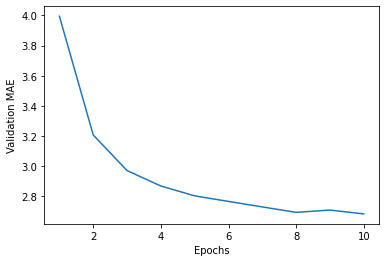

In [108]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


It may be a bit hard to see the plot due to scaling issues and relatively high variance. Let's:

* Omit the first 10 data points, which are on a different scale from the rest of the curve.
* Replace each point with an exponential moving average of the previous points, to obtain a smooth curve.

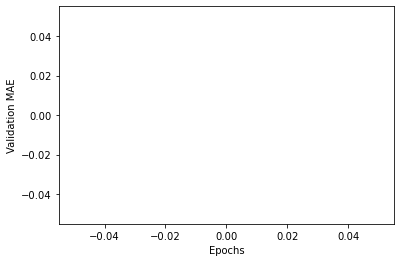

In [100]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [102]:
smooth_mae_history

[]

According to this plot, it seems that validation MAE stops improving significantly after 80 epochs. Past that point, we start overfitting.

Once we are done tuning other parameters of our model (besides the number of epochs, we could also adjust the size of the hidden layers), we can train a final "production" model on all of the training data, with the best parameters, then look at its performance on the test data:

In [ ]:
batch_size = 16
num_epochs = 80
# Generate a new estimator.
est = Estimator.from_keras(model_creator=build_model,
                           config={},
                           workers_per_node=1,
                           verbose=0)
# Train it on the entirety of the data.
stats = est.fit(train_data_creator, 
                epochs=num_epochs,
                batch_size=batch_size,
                steps_per_epoch=404 // batch_size,
                data_config={"mean": mean, "std": std, "batch_size": batch_size, "K-fold": False},
                verbose=0)
val_stats = est.evaluate(val_data_creator, 
                         data_config={"mean": mean, "std": std, "batch_size": 1, "K-fold": False},
                         num_steps=102 // batch_size)
est.shutdown()

In [ ]:
print(val_stats)

We are still off by \$ 2,652.

## Wrapping up
Here's what you should take away from this example:

* Regression is done using different loss functions from classification; Mean Squared Error (MSE) is a commonly used loss function for regression.
* Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally the concept of "accuracy" does not apply for regression. A common regression metric is Mean Absolute Error (MAE).
* When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
* When there is little data available, using K-Fold validation is a great way to reliably evaluate a model.
* When little training data is available, it is preferable to use a small network with very few hidden layers (typically only one or two), in order to avoid severe overfitting.

This example concludes our series of three introductory practical examples. You are now able to handle common types of problems with vector data input:

* Binary (2-class) classification.
* Multi-class, single-label classification.
* Scalar regression.

In the next chapter, you will acquire a more formal understanding of some of the concepts you have encountered in these first examples, such as data preprocessing, model evaluation, and overfitting.

In [ ]:
# stop orca context when program finishes
stop_orca_context()